# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops


<img src="https://cdn11.bigcommerce.com/s-jl3t5tg/product_images/uploaded_images/rwanda7.jpg" width="800" height="200"/>

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called soil_measures.csv, which contains:

- "N": Nitrogen content ratio in the soil
- "P": Phosphorous content ratio in the soil
- "K": Potassium content ratio in the soil
- "pH" value of the soil
- "crop": categorical values that contain various crops (target variable).
Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the "crop" column is the optimal choice for that field.

In this project, we will build multi-class classification models to predict the type of "crop" and identify the single most importance feature for predictive performance.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import numpy as np
import shap
import matplotlib.pyplot as plt

In [2]:
crops = pd.read_csv("soil_measures.csv")

In [3]:
crops.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [4]:
features = ["N", "P", "K", "ph"]

In [5]:
X = crops[features]
y = crops["crop"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [8]:
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

In [9]:
log_reg = LogisticRegression(solver="lbfgs")
log_reg.fit(X_train, y_train)

LogisticRegression()

## Feature Coefficients

In [10]:
log_reg.coef_

array([[-1.30863631,  3.86091223,  4.37194563, -1.14920563],
       [ 3.72555458,  5.16728903,  1.62359302, -1.02977289],
       [ 0.00964744,  4.53845813, -3.78362807,  1.01148817],
       [-1.23230444,  0.73258676,  5.11716717,  1.33887212],
       [-2.0377678 , -5.22451544,  0.25522344, -0.70972524],
       [ 3.8932807 , -3.87264824, -3.3083339 ,  0.81267419],
       [ 6.49713965,  1.00899788, -4.83767338,  0.85766773],
       [-0.74427144,  3.16075905,  5.20215009, -0.40578568],
       [ 2.11406818,  0.02846361,  1.29265868,  0.55078223],
       [-2.4312558 ,  4.08948656, -1.63286328, -0.96720017],
       [-3.18757588,  4.49471718, -2.40895629,  0.76524064],
       [ 2.23350689,  0.27828397, -5.87413754, -0.53510582],
       [-2.60335868, -3.00873746,  0.43960462, -0.98536646],
       [-2.56364035, -0.10361535, -2.55828264,  0.69868381],
       [-2.72191825, -0.29195515, -2.90876463,  0.33599361],
       [ 3.36004117, -5.00844362,  3.8953712 , -0.80283457],
       [-2.16656699, -5.

In [11]:
coefficient_means = np.mean(abs(log_reg.coef_), axis=0)
for feature, mean in zip(features, coefficient_means):
    print(f"The mean coefficient of the feature {feature} is {mean:.2f}")

The mean coefficient of the feature N is 2.45
The mean coefficient of the feature P is 2.99
The mean coefficient of the feature K is 3.18
The mean coefficient of the feature ph is 0.72


We now have the relative importance, assuming linear relationships. However, this doesn't measure how prediction performance would change if a feature was removed.

## Model Performance when trained on each feature: F1 score

In [12]:
performance = {}

for feature in features:
    log = LogisticRegression(solver="lbfgs", max_iter=300)
    log.fit(X_train[[feature]], y_train)
    y_pred = log.predict(X_test[[feature]])

    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    performance[feature] = f1

performance

{'N': 0.11471894842191138,
 'P': 0.09864234666086195,
 'K': 0.14559954420109014,
 'ph': 0.04685811534301858}

It is clear that Potassium, "K" has the highest raw predictive power for determining optimal crop choice for a field. Nitrogen, "N" follows closely, while the PH balance of the soil looks almost insiginificant. However, we need to take into accound the relationships between the feaures themselves. Maybe PH + P exudes more influence than N alone. And that is why we are going to explore SHAP. SHAP (SHapley Additive exPlanations) is one of the most powerful and interpretable tools to understand feature importance and individual predictions.  

## SHAP 
"The core idea behind ShAP value based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model’s output 
among its input features. In order to connect game theory with machine learning models, it is necessary to both match a model’s input features with players in a game, and also match the model function with the rules of the game. Since in game theory a player can join or not join a game, we need a way for a feature to “join” or “not join” a model." — Official docs
https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [13]:
shap.initjs()

In [14]:
explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer(X_train)

### Individual Data Point Feature Contribution: Feature-wise contribution in the model's classification of a particular data point into a particular class. 
Waterfall plots are designed to display explanations for individual predictions. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

In this case, we are going to be choosing a data point at random, then explore each feature's individual contribution to the model's decision to classify it into a particular crop class.

In [15]:
num_classes = shap_values.values.shape[2]
n = len(X_train)

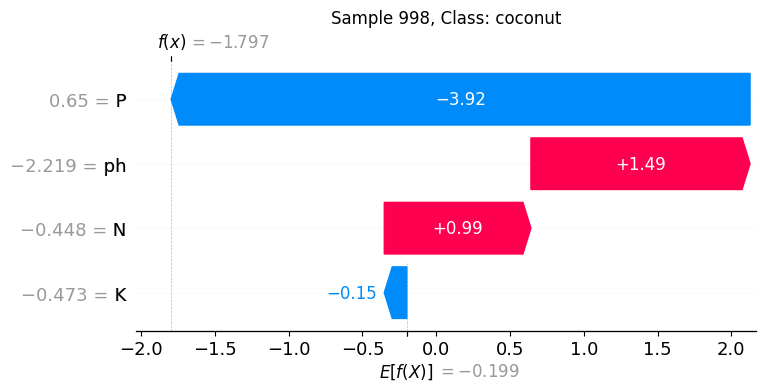

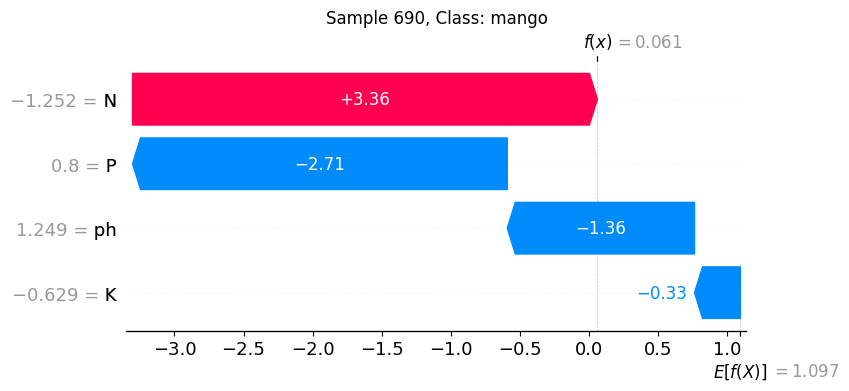

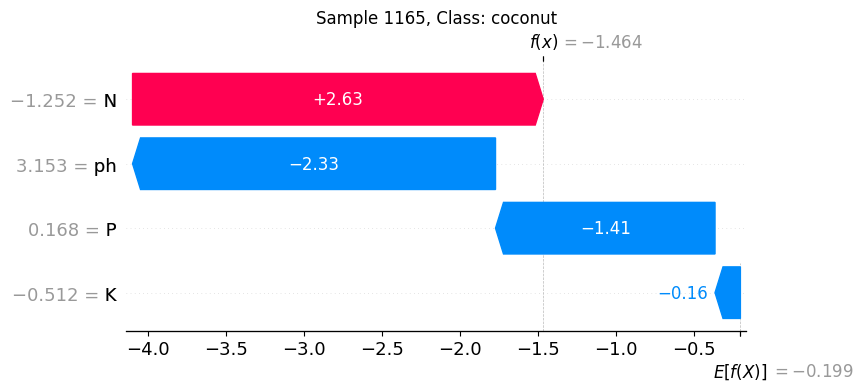

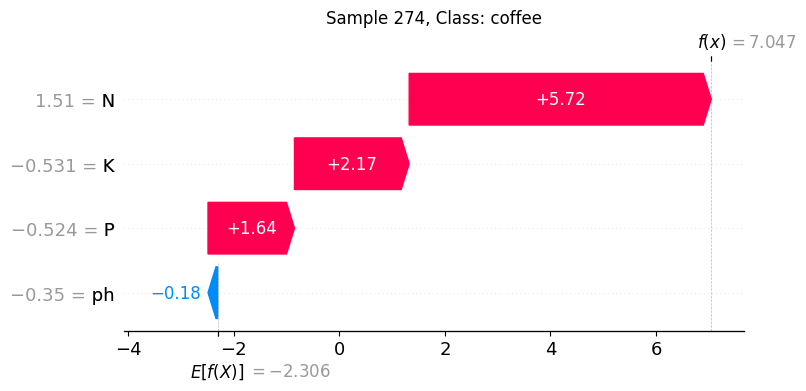

In [16]:
for _ in range(4):
    index = np.random.randint(n)  # Random data point
    class_index = np.random.randint(num_classes)  # Random class index
    class_name = le.inverse_transform([class_index])[0]  # Crop name from earlier LabelEncoder
    
    explanation = shap.Explanation(
        values=shap_values[:, :, class_index],
        base_values=shap_values.base_values[:, class_index],
        data=X_train,
        feature_names=features
    )

    shap.plots.waterfall(explanation[index], show=False)
    plt.title(f"Sample {index}, Class: {class_name}")
    plt.show()


### Class-wise Feature Contribution: Feature-wise contribution in the model's classification of all points to a particular class. 
Now, let’s explore the model’s behavior crop-wise. For each of the five randomly selected crop classes out of our total of twenty-two, we will examine how the individual features influence the model’s decision to classify all data points that were classified into that specific crop class.

SHAP summary plot for class: blackgram


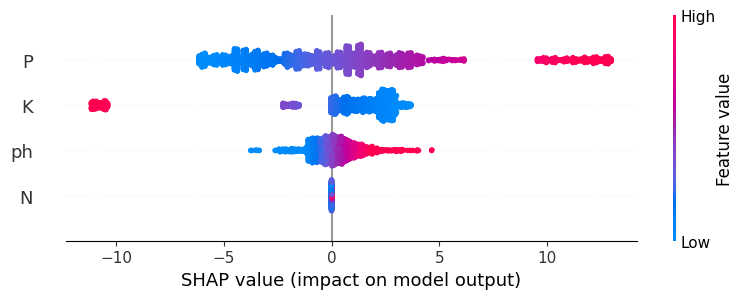

SHAP summary plot for class: maize


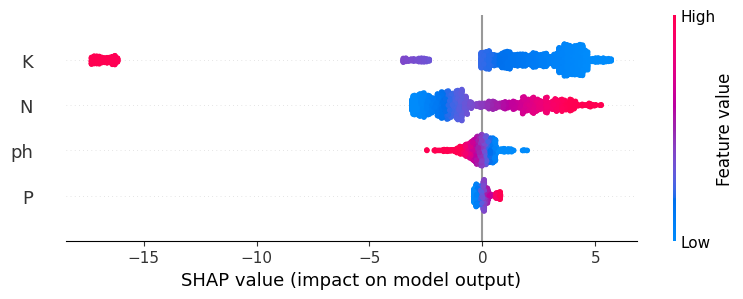

SHAP summary plot for class: pigeonpeas


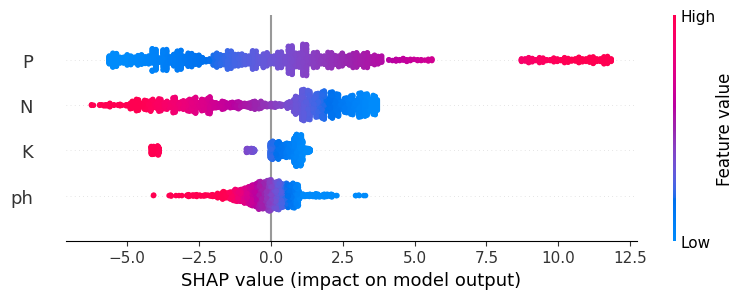

SHAP summary plot for class: orange


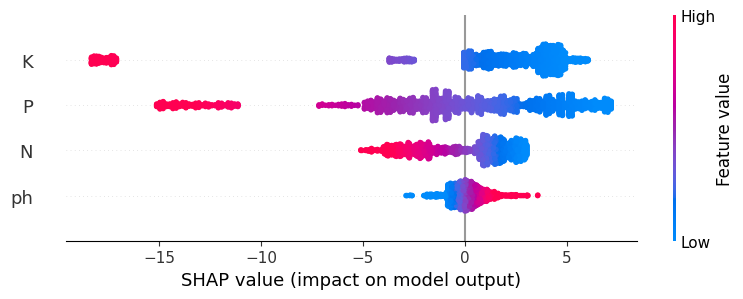

SHAP summary plot for class: banana


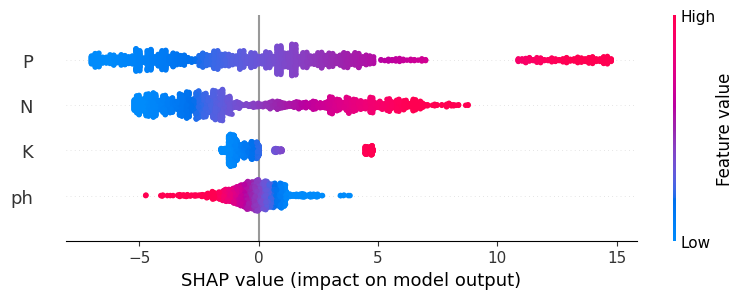

In [17]:
num_classes = len(le.classes_)

for _ in range(5):
    class_index = np.random.randint(num_classes)
    class_name = le.classes_[class_index]
    print(f"SHAP summary plot for class: {class_name}")
    shap.summary_plot(
        shap_values[:, :, class_index],  
        X_train,                         # feature data
        feature_names=features,
        show=True
    )

## Dependence Scatter Plot

A dependence scatter plot illustrates how a single feature influences the model's predictions.
In this case, the plot uses SHAP values aggregated across all 22 crop classes.

To highlight potential interaction effects between features, the `color=explanation` argument is used. This reveals how the selected feature interacts with others—specifically, the one it most frequently pairs with in driving the prediction is shown on the right side of the graph.

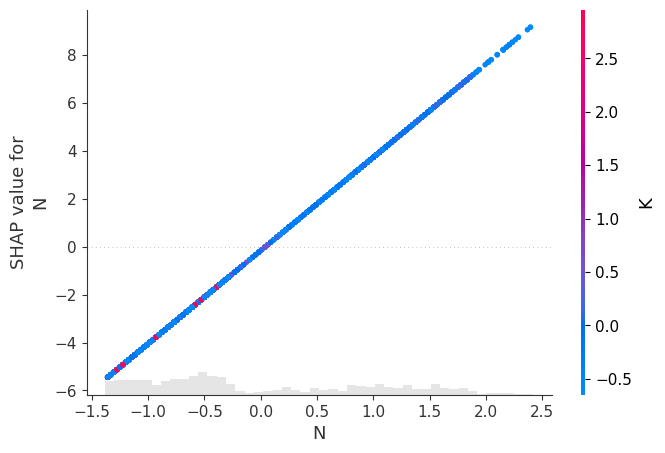

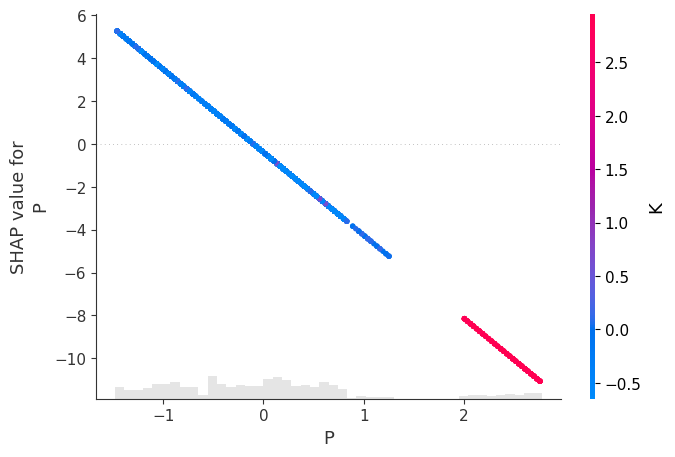

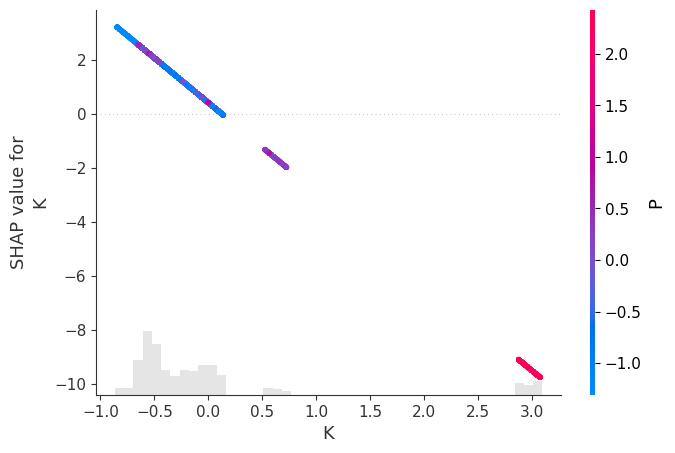

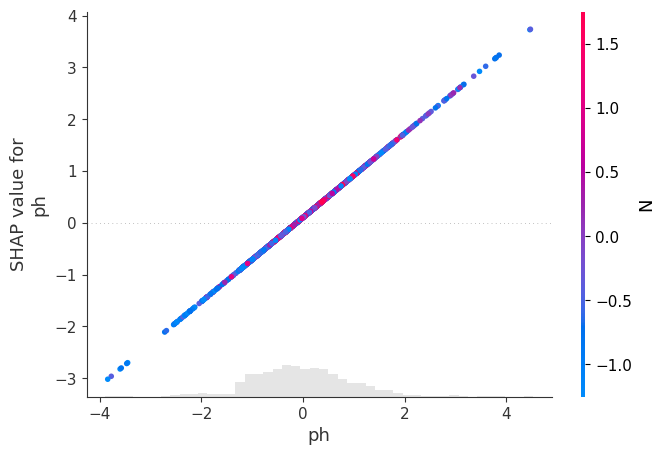

In [18]:
for feature in features:
    shap.plots.scatter(explanation[:, feature], color=explanation)

## The bigger picture: How each feature influences classification accross all classes.

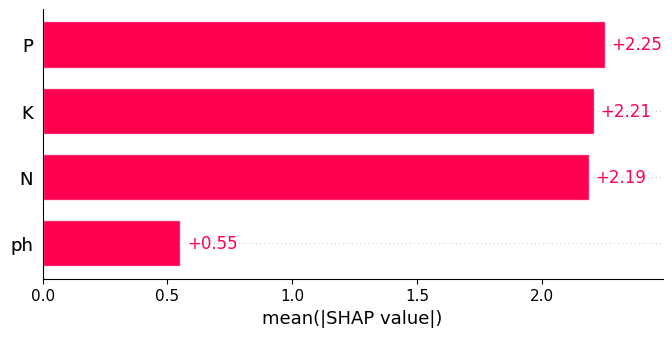

In [19]:
# Aggregate SHAP values across classes
shap_means = np.mean(np.abs(shap_values.values), axis=2)  

#Use mean base values 
base_vals = np.mean(shap_values.base_values, axis=1) 

exp = shap.Explanation(
    values=shap_means,
    base_values=base_vals,
    data=X_train,
    feature_names=features
)

shap.plots.bar(exp)